In [1]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
from rasterio.features import rasterize
from rasterio.enums import Resampling
import os
import numpy as np
import glob
from rasterio.plot import show
from shapely.geometry import Polygon
import itertools
from rasterio import mask
import re
import random
import time
from tqdm.notebook import tqdm

In [2]:
# set working directory
#os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set whether to pull full tiles from external disk
#external_path = None
external_path = '/mnt/d/202109'

# set I/O directories
train_poly_DIR = './train_polys'
#train_tiles_DIR = './train_tiles'
train_tiles_DIR = os.path.join(external_path, 'train_tiles')

outDIR_imgs = './cnn_train_images'
outDIR_labs = './cnn_train_labels'

# create output directories if necessary
if not os.path.exists(outDIR_imgs):
    os.mkdir(outDIR_imgs)
if not os.path.exists(outDIR_labs):
    os.mkdir(outDIR_labs)

# set list of trainers and training tile groups
trainer_list = ['Sean', 'Lauren', 'David']
group_list = ['random', 'group', 'group2']

In [3]:
# loop through all trainers and groups to create concatenated training dataset
idx = 0
for trainer in trainer_list:
    for group in group_list:
        if group != 'random' and trainer != 'Sean':
            continue
        else:
            print('_'.join([trainer, group]))
            inDIR = os.path.join(train_poly_DIR, '_'.join([trainer, group]))
            poly_flist = list(filter(os.path.isfile, 
                                glob.glob(inDIR + '/delim_' + '_'.join([trainer, group]) + '*.shp')))
            if len(poly_flist) > 0:
                poly_flist.sort(key=lambda x: os.path.getctime(x))
            else:
                print('ERROR: No shapefiles found')
                continue                            
            poly_f = poly_flist[-1]
            train_polys_tmp = gpd.read_file(poly_f)
            train_polys_tmp['group'] = group
            if idx == 0:
                train_polys = train_polys_tmp
            else:
                train_polys = pd.concat([train_polys, train_polys_tmp])
            idx += 1

# set CRS of training dataset
train_polys = train_polys.set_crs(32613).reset_index().rename(columns={'index':'orig_index'})

Sean_random
Sean_group
Sean_group2
Lauren_random
David_random


In [4]:
# drop bad polygon identified by David
train_polys = train_polys[~((train_polys['Trainer'] == 'David') & (train_polys['Tile'] == '22W_0') & (train_polys['Comment'] == 'NoB'))].copy()

In [5]:
# get any duplicated tiles from group2
rand_tile_list = train_polys[train_polys['group'] == 'random']['Tile'].unique()
group_tile_list = train_polys[train_polys['group'] == 'group']['Tile'].unique()
group2_tile_list = train_polys[train_polys['group'] == 'group2']['Tile'].unique()
dup_tile_list = [item for item in group2_tile_list if item in rand_tile_list or item in group_tile_list]
print('removing duplicated tiles: ')
display(dup_tile_list)

# drop any tiles from group2 if they also appear in random group
train_polys = train_polys[~((train_polys['group'] == 'group2') &
                            (train_polys['Tile'].isin(dup_tile_list)))]

removing duplicated tiles: 


[]

In [6]:
train_polys['Tile'].unique()

array(['CN_44', '5W_14', '5W_13', 'CN_46', 'CN_18', 'CN_10', '29-30_46',
       'CN_49', 'CN_27', '22E_12'], dtype=object)

In [7]:
# read in list of training tiles
df_tiles = pd.read_csv(os.path.join('./train_tiles', 'train_bboxes_all_assigned.csv'))

# get unique id's for each polygon within each tile
train_polys['subID'] = train_polys.groupby('Tile').transform(lambda x: np.arange(len(x)))['Comment']

# save concatenated training polygon dataset
#train_polys.to_csv('train_polys/train_polys_all.csv')

##OR##

from shapely import wkt
# read in training polygons
df_train_polys = pd.read_csv('train_polys/train_polys_all.csv')
df_train_polys['geometry'] = df_train_polys['geometry'].apply(wkt.loads)
train_polys = gpd.GeoDataFrame(df_train_polys, crs='32613')

In [8]:
train_polys

,Unnamed: 0,orig_index,Comment,Tile,Trainer,geometry,group,subID
0,0,0,NaN,CN_50,Sean,"POLYGON ((519835.548 4516699.658, 519836.043 4...",random,0
1,1,1,NaN,CN_50,Sean,"POLYGON ((519837.998 4516708.403, 519838.603 4...",random,1
2,2,2,NaN,CN_50,Sean,"POLYGON ((519828.005 4516706.137, 519828.336 4...",random,2
3,3,3,NaN,CN_50,Sean,"POLYGON ((519849.530 4516703.545, 519850.209 4...",random,3
4,4,4,NaN,CN_50,Sean,"POLYGON ((519849.728 4516697.939, 519850.294 4...",random,4
...,...,...,...,...,...,...,...,...
374,448,64,NaN,22W_14,David,"POLYGON ((519588.080 4518187.215, 519589.099 4...",random,3
375,449,65,NaN,22W_14,David,"POLYGON ((519587.764 4518179.192, 519589.064 4...",random,4
376,450,66,NaN,22W_0,David,"POLYGON ((519853.938 4519328.380, 519854.331 4...",random,0
377,451,67,NaN,22W_0,David,"POLYGON ((519860.298 4519320.625, 519860.859 4...",random,1


In [12]:
def crop_and_save(rgb_path, label_polys, geom, prefix, win_size):
    coords_x = np.array(geom.bounds)[[0, 2]]
    coords_y = np.array(geom.bounds)[[1, 3]]
    # get the box coordinate pairs
    ll, ul, lr, ur = list(itertools.product(coords_x, coords_y))
    with rio.open(rgb_path) as src_rgb:   
        profile_rgb = src_rgb.meta
        rgb_out, transform_out = mask.mask(src_rgb,
                                           [geom],
                                           crop=True)
        rgb_out = rgb_out[:, -win_size:, :win_size]
        ll_i = src_rgb.index(*ll)
        ur_i = src_rgb.index(*ur)
        if len(label_polys) > 0:
            label = rasterize(label_polys.geometry, 
                              out_shape=src_rgb.shape, 
                              transform=src_rgb.transform)
        else:
            label = np.zeros(src_rgb.shape)
        label = label[ll_i[0]-win_size:ll_i[0], ll_i[1]:ll_i[1] + win_size]
        
        profile_rgb.update({'dtype': 'int16',
                            'width': win_size,
                            'height': win_size,
                            'transform': transform_out})
        profile_single = profile_rgb.copy()
        profile_single.update({'count': 1})
        profile_single_float = profile_single.copy()
        profile_single_float.update({'dtype': 'float64'})
        tile_basename_rgb = os.path.basename(rgb_path)
        with rio.open(os.path.join(outDIR_imgs, prefix + '_' + tile_basename_rgb), 'w', **profile_rgb) as dst:
            dst.write(rgb_out)
        with rio.open(os.path.join(outDIR_labs, prefix + '_' + re.sub('_rgb', '_labels', tile_basename_rgb)), 'w', **profile_single) as dst:
            dst.write(label, 1)
        for suffix in ['ndvi', 'dsm', 'shade', 'tpi']:
            with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
                profile_i = src_i.profile
                i_out = src_i.read(out_shape=(
                    src_i.count,
                    src_rgb.meta['height'],
                    src_rgb.meta['width']),
                                   resampling=Resampling.bilinear)
                i_out = i_out[:, ll_i[0]-win_size:ll_i[0], ll_i[1]:ll_i[1] + win_size]
                profile_i.update({'width': i_out.shape[2],
                                  'height': i_out.shape[1],
                                  'transform': transform_out})
                with rio.open(os.path.join(outDIR_imgs, prefix + '_' + re.sub('rgb', suffix, tile_basename_rgb)), 'w', **profile_i) as dst:
                    dst.write(i_out)

In [13]:
len(df_tiles['ID'][(df_tiles['trainer'] != 'Nick') &
                         (df_tiles['Digitize'] == 1)])

105

5W_7


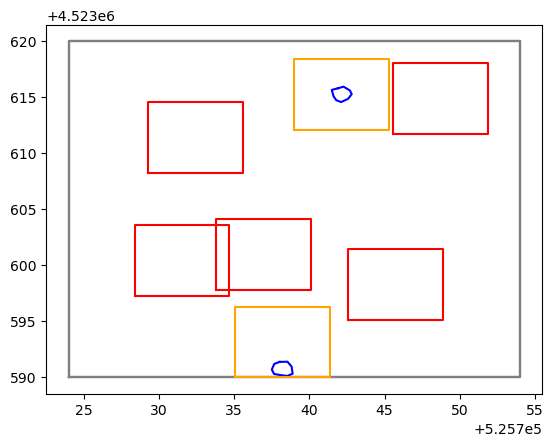

5W_9


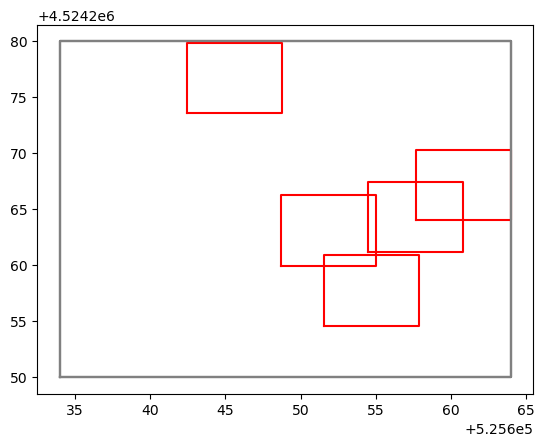

5W_14


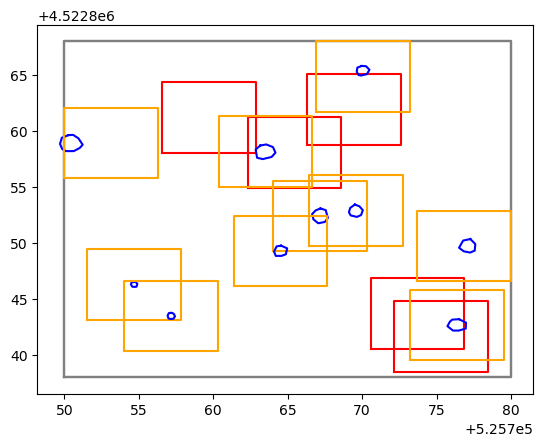

22W_2


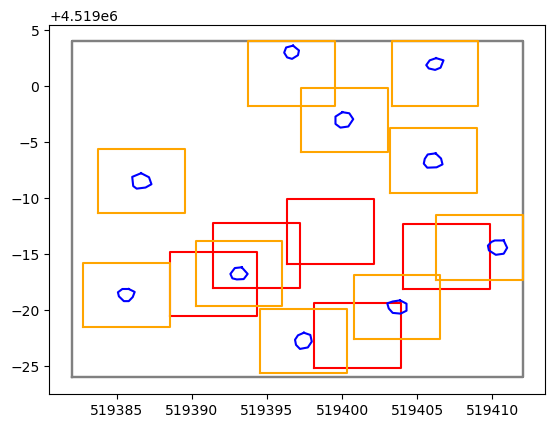

22W_6


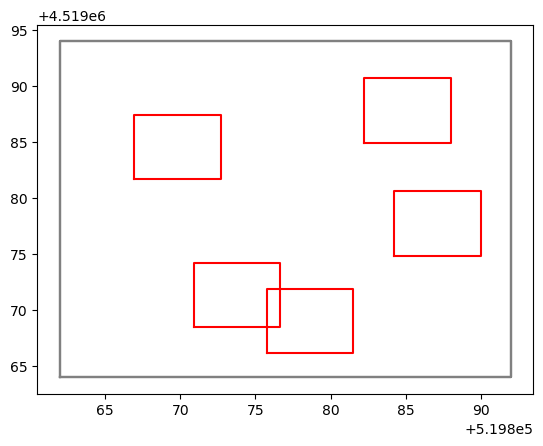

22W_10


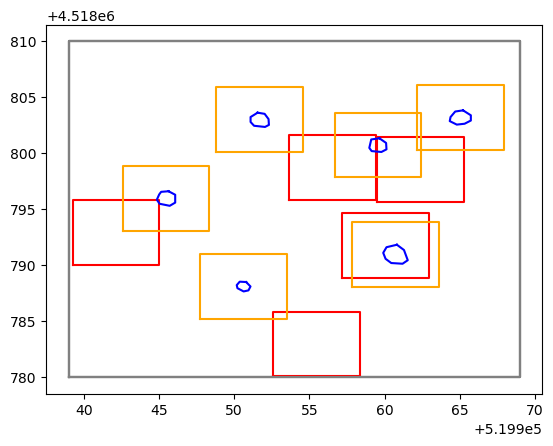

22E_0


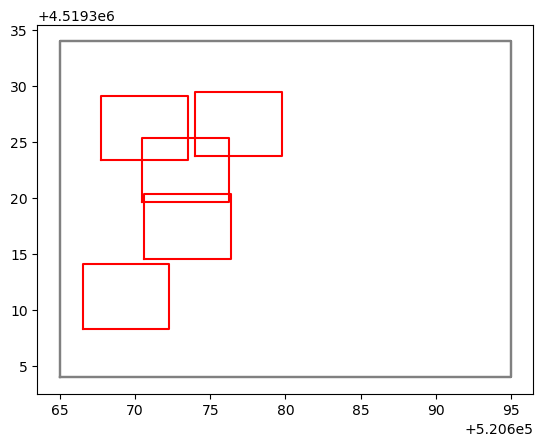

22E_5


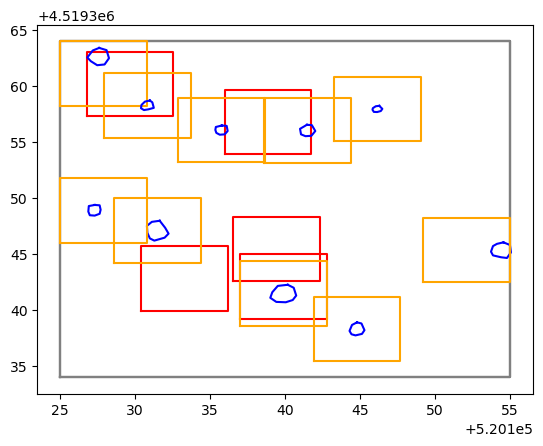

22E_13


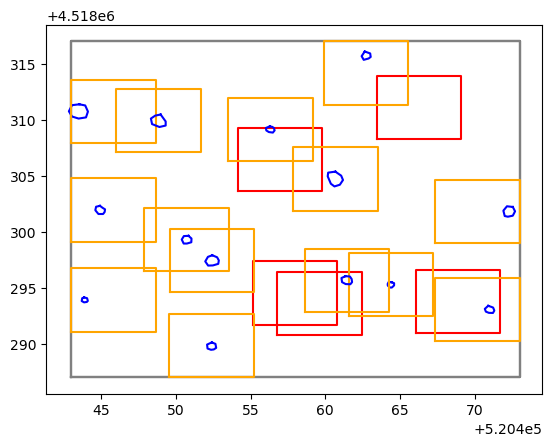

29-30_16


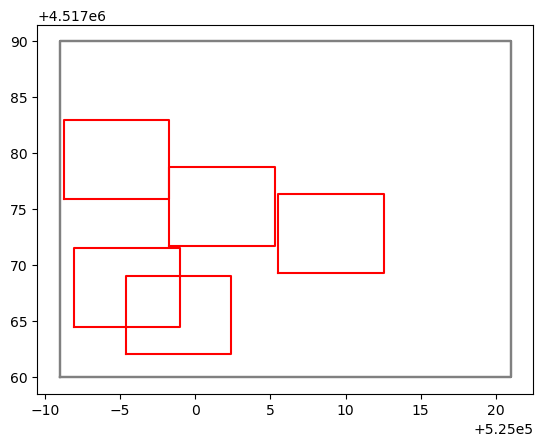

29-30_24


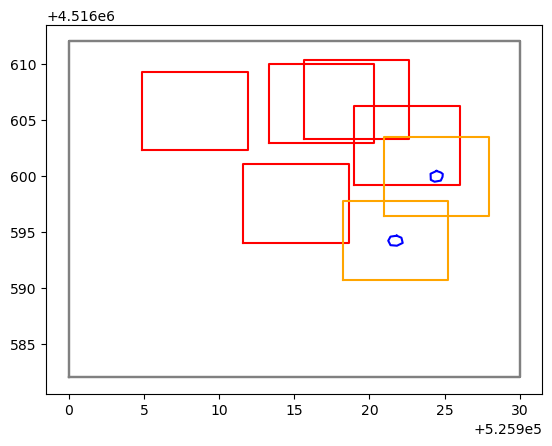

29-30_40


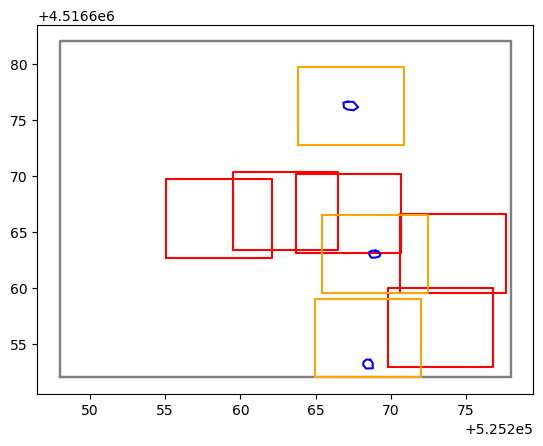

CN_4


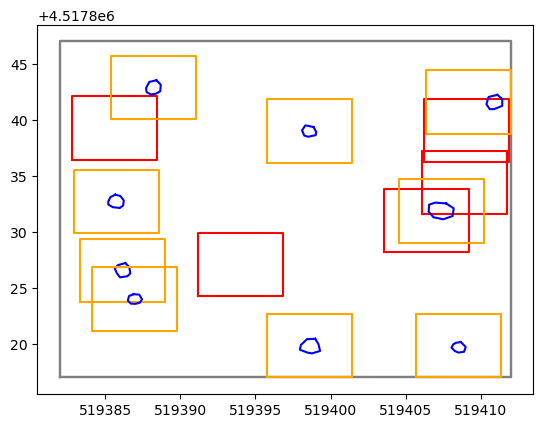

CN_5


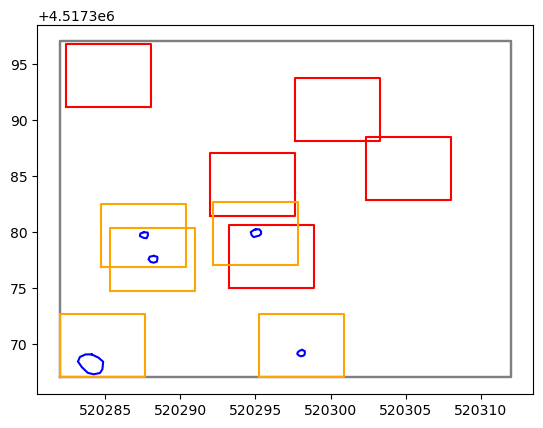

CN_14


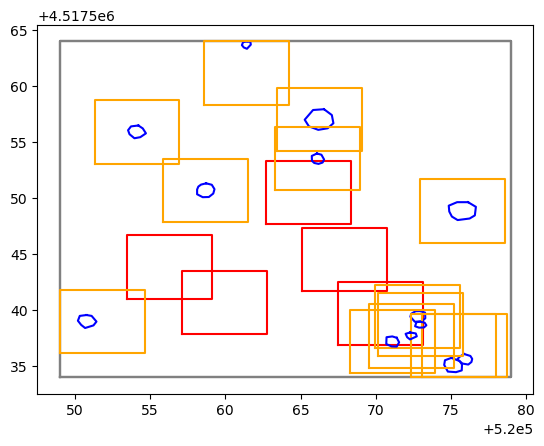

29-30_18


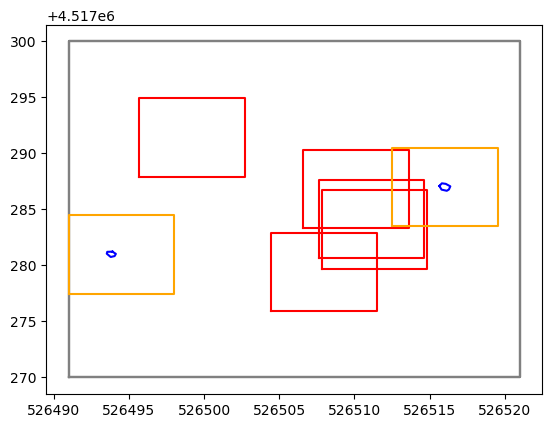

22W_7


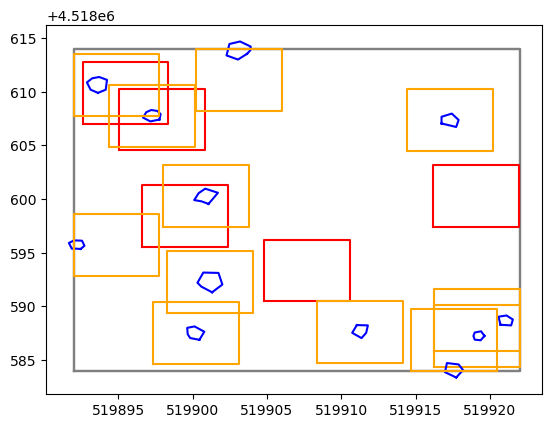

5W_5


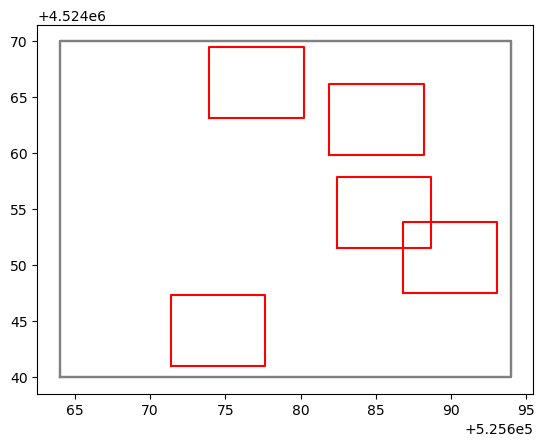

CN_54


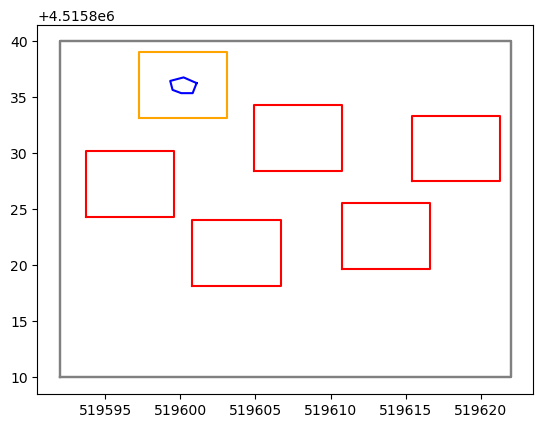

5W_11


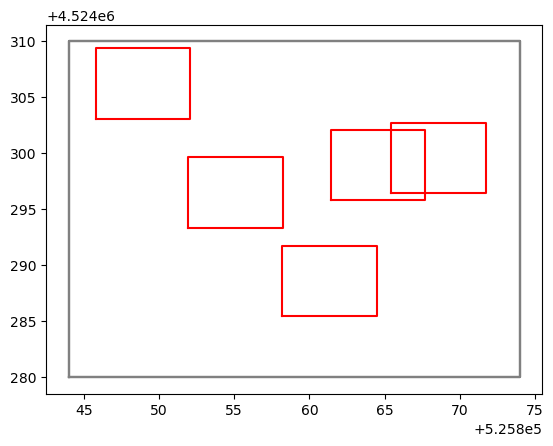

29-30_0


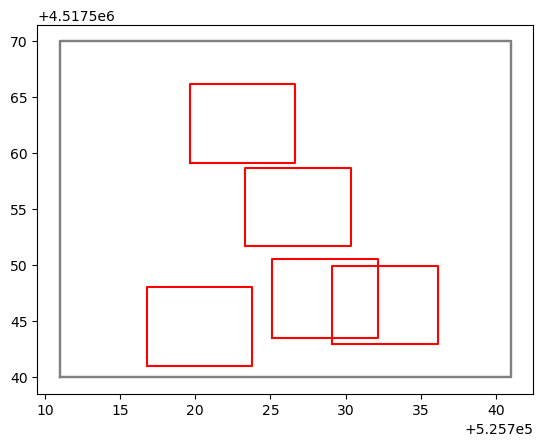

CN_35


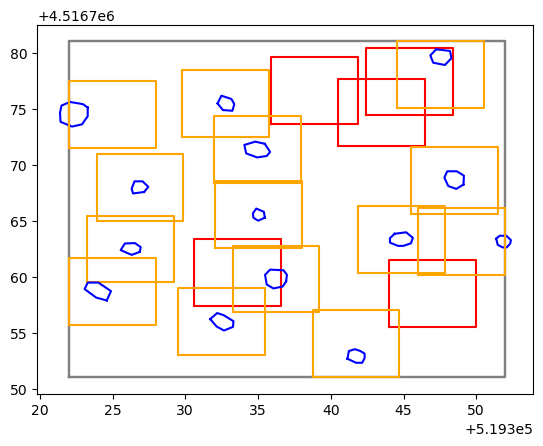

CN_7


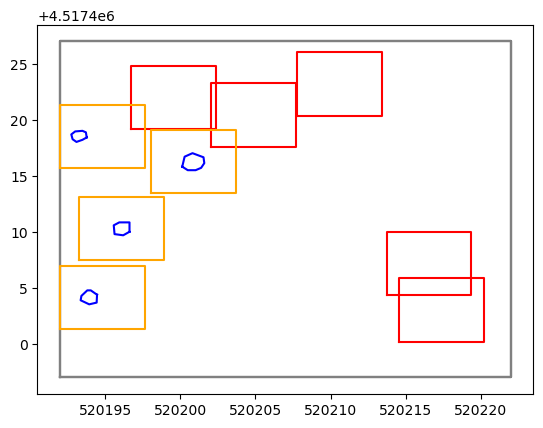

29-30_7


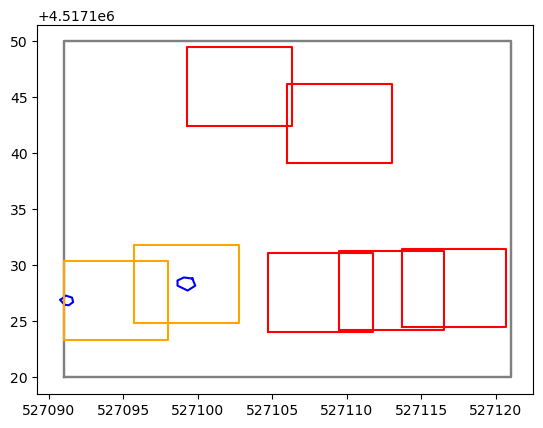

CN_9


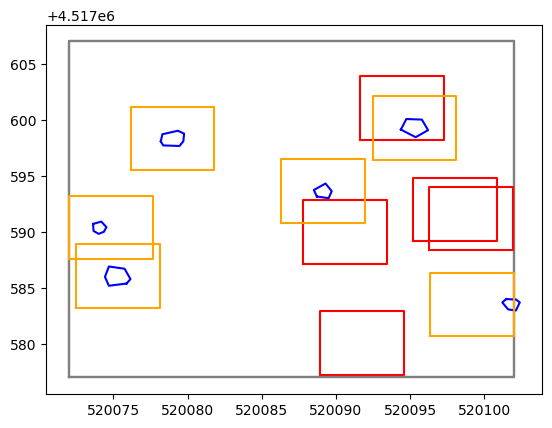

CN_6


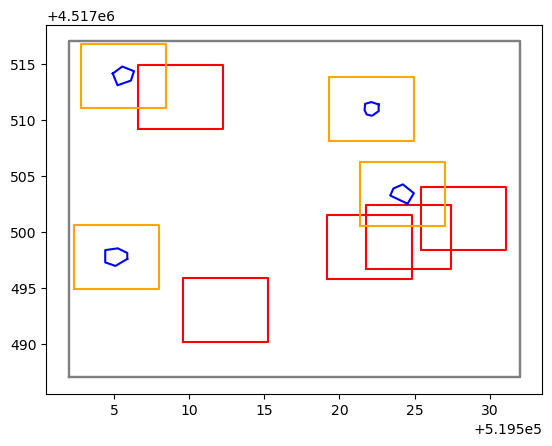

22W_8


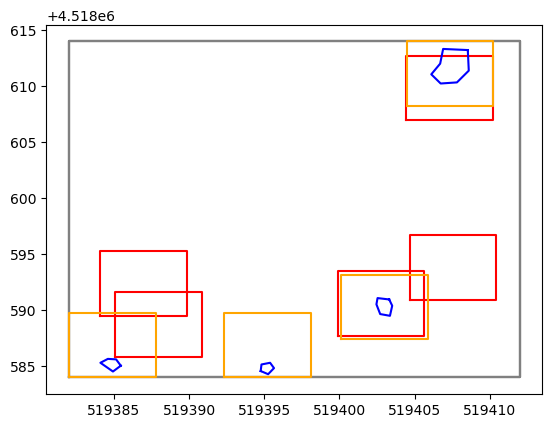

5W_8


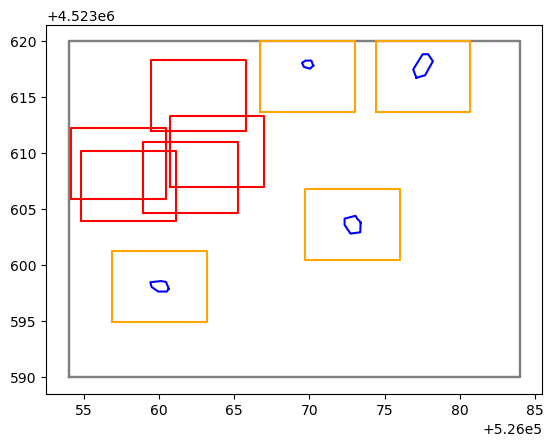

22E_8


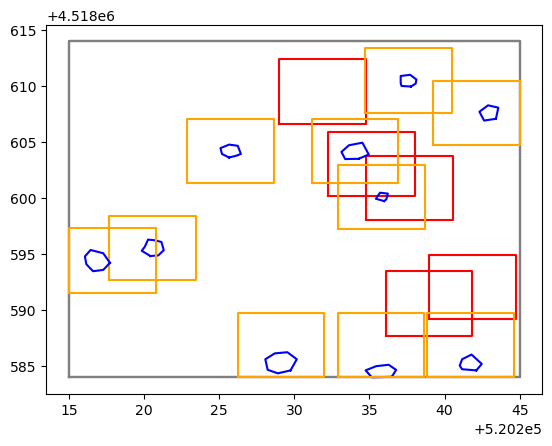

CN_26


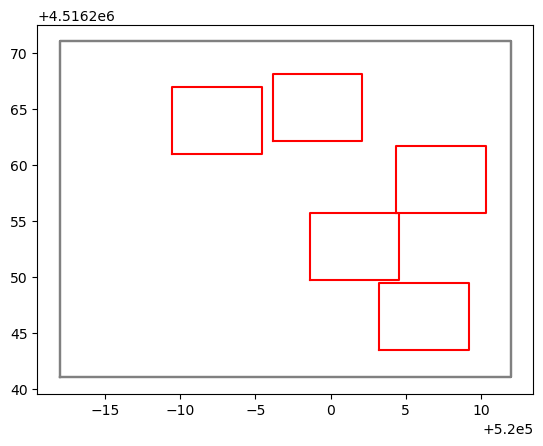

22E_9


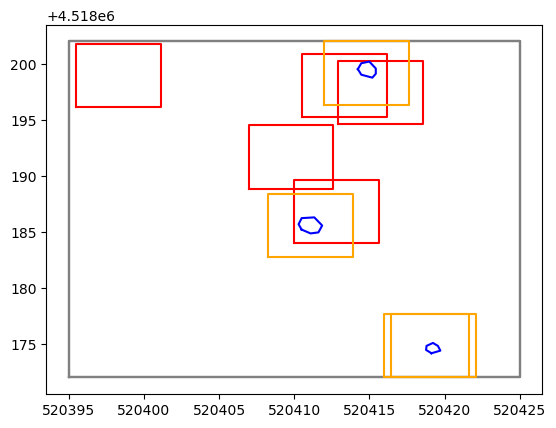

29-30_8


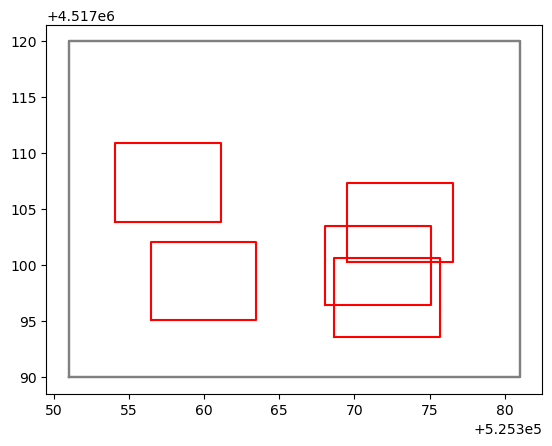

22W_13


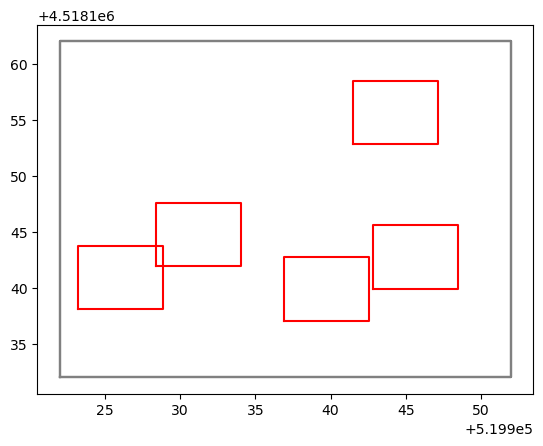

CN_3


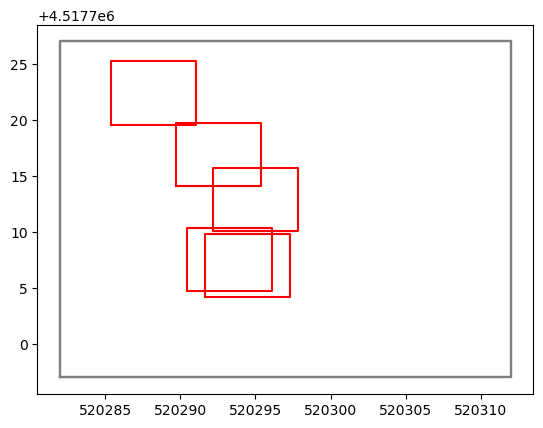

CN_52


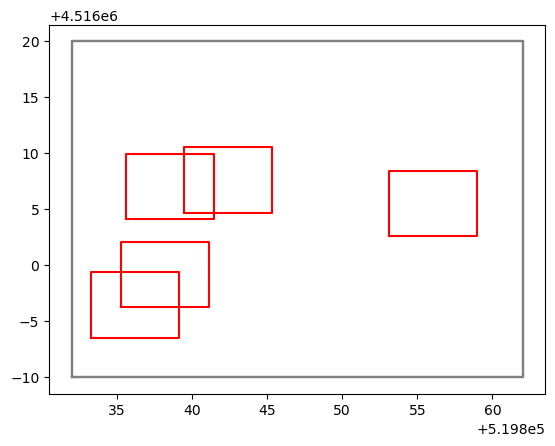

CN_27


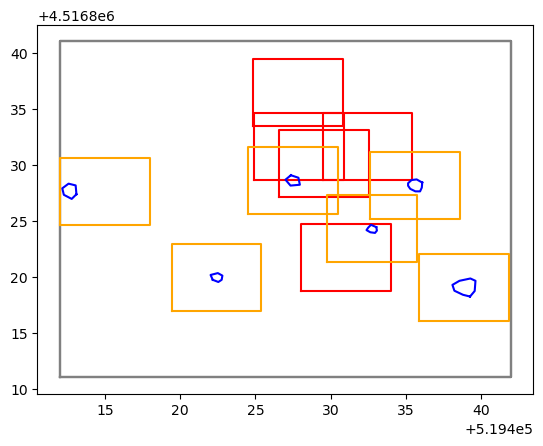

CN_55


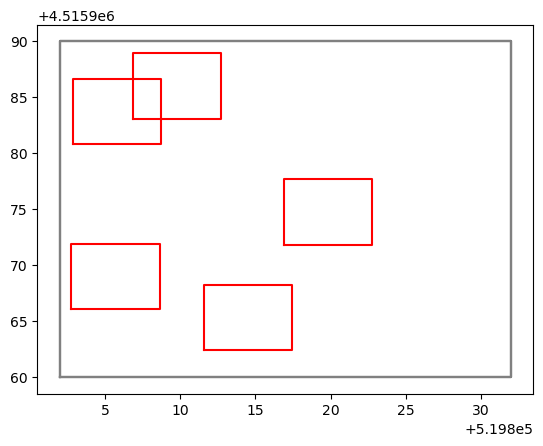

CN_49


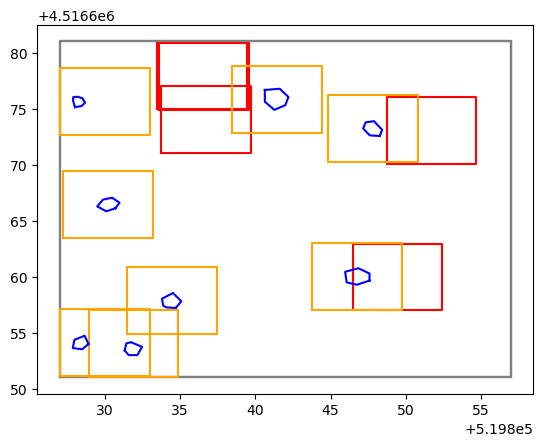

29-30_46


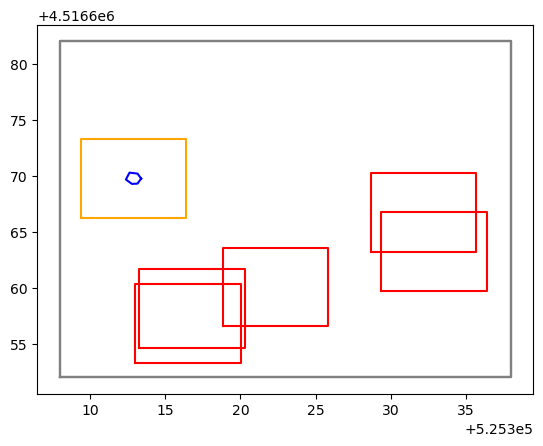

29-30_10


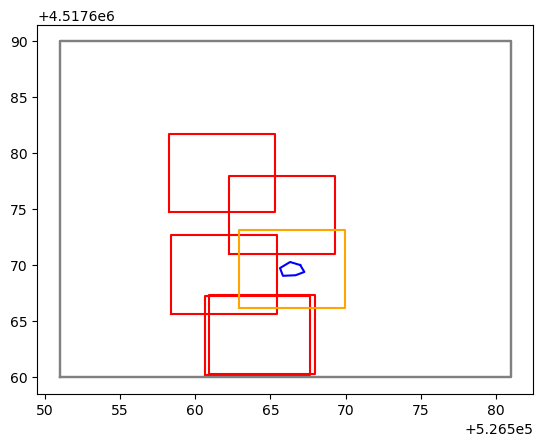

CN_51


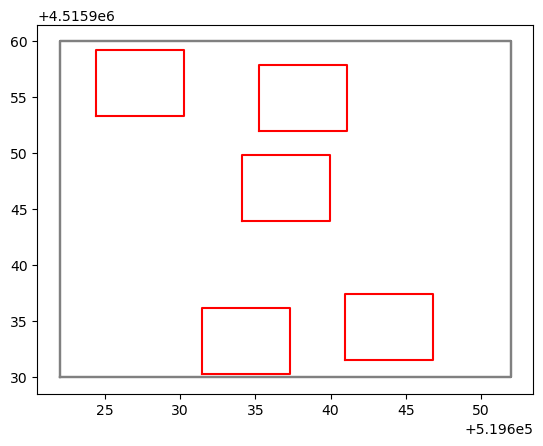

CN_10


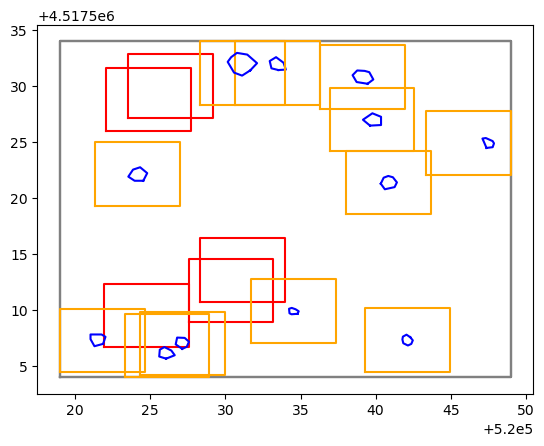

CN_18


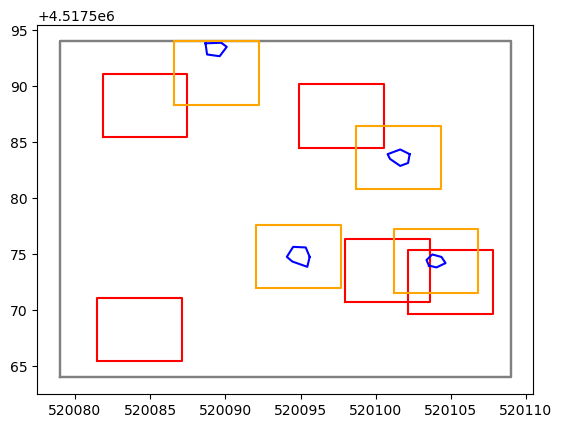

CN_53


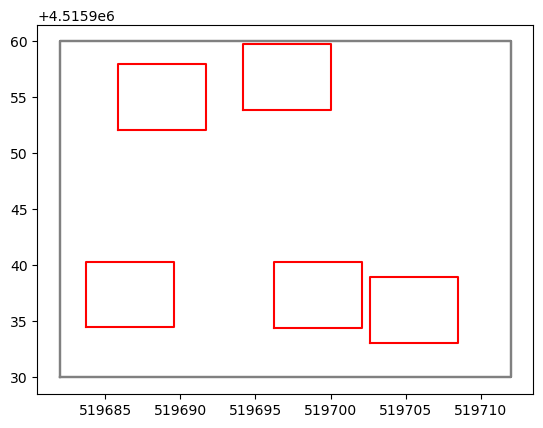

CN_46


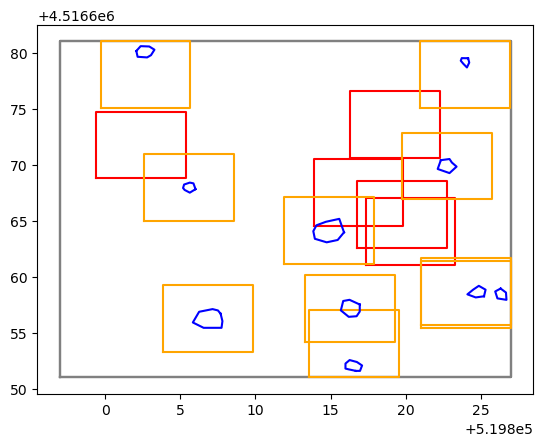

22W_14


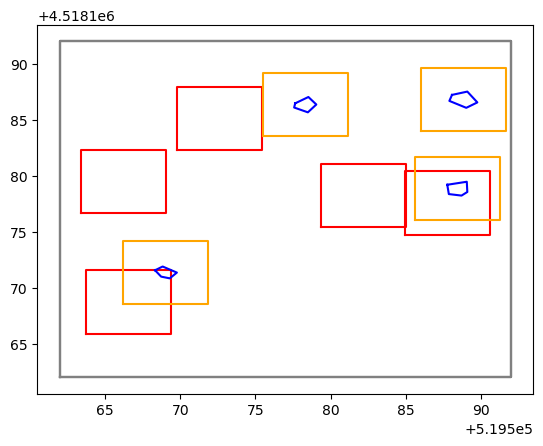

CN_1


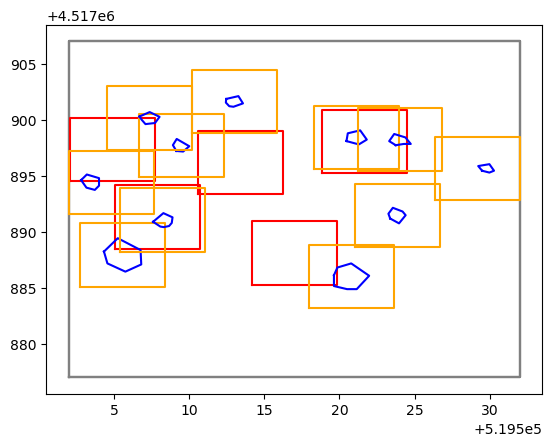

22E_12


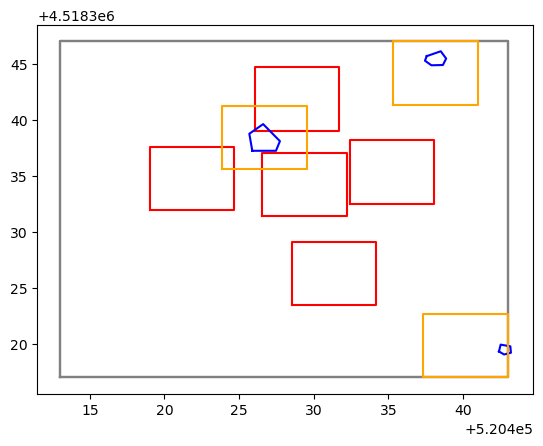

29-30_37


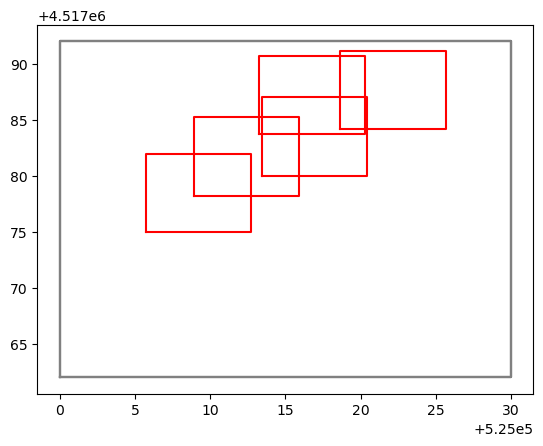

CN_43


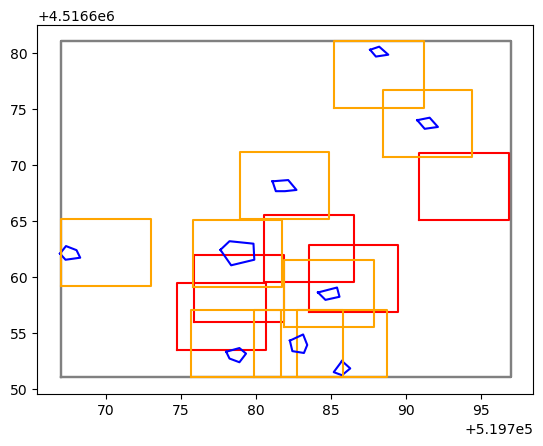

29-30_33


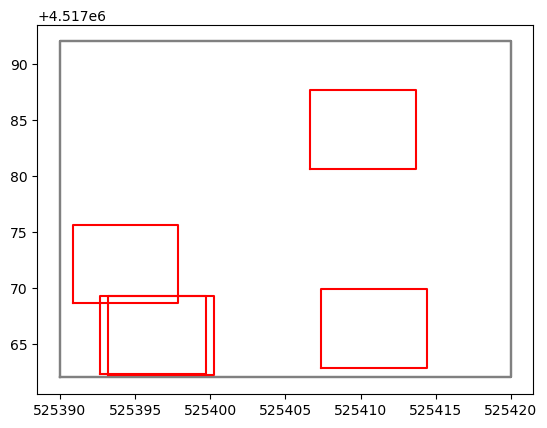

22W_5


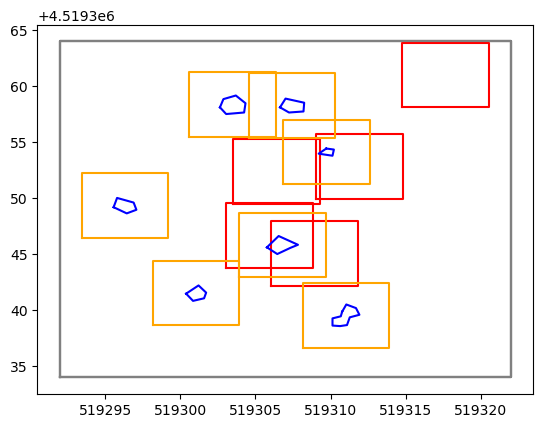

29-30_32


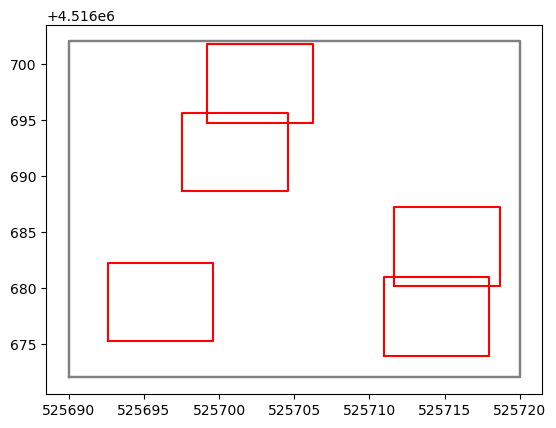

29-30_22


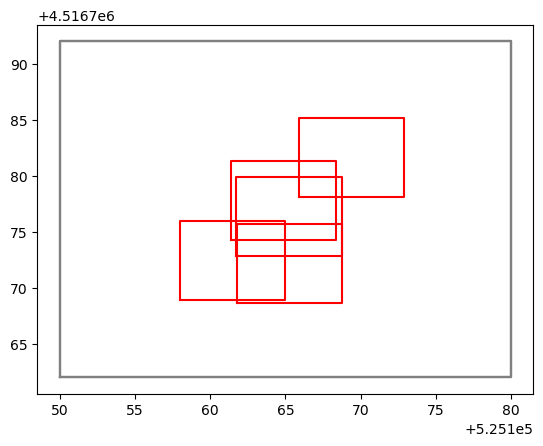

22W_0


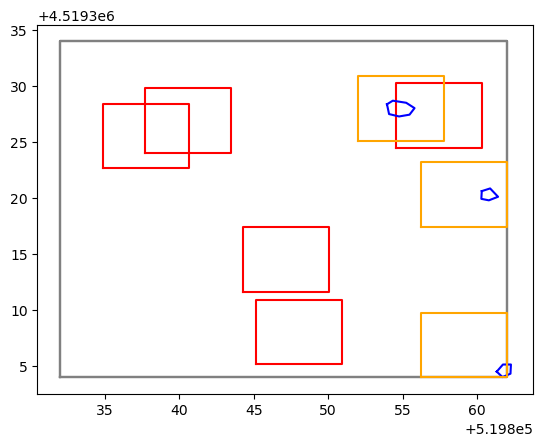

22W_11


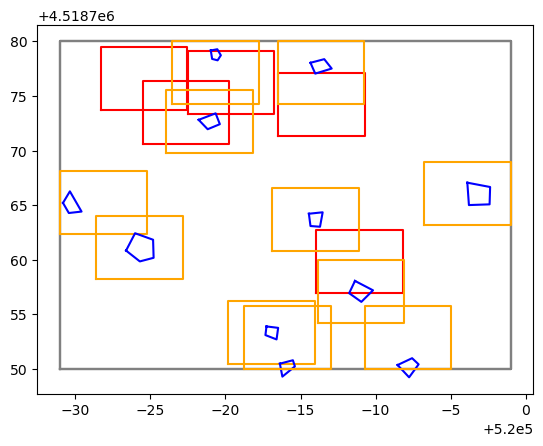

CN_38


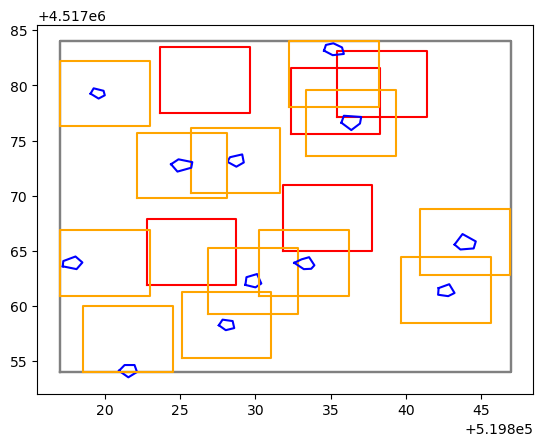

22E_7


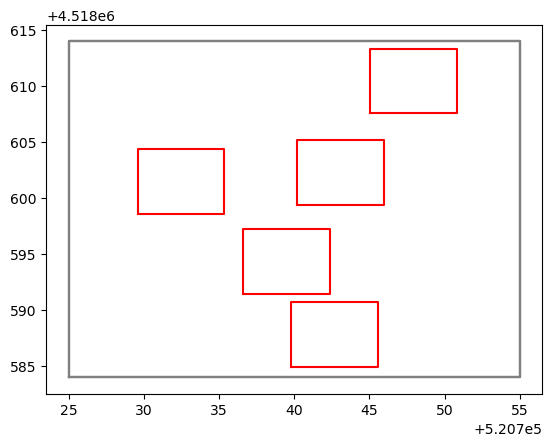

29-30_5


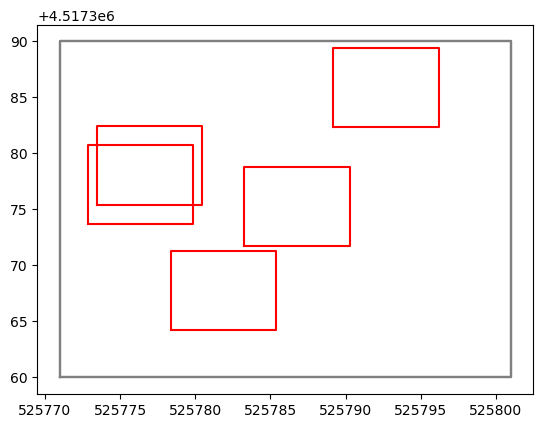

29-30_29


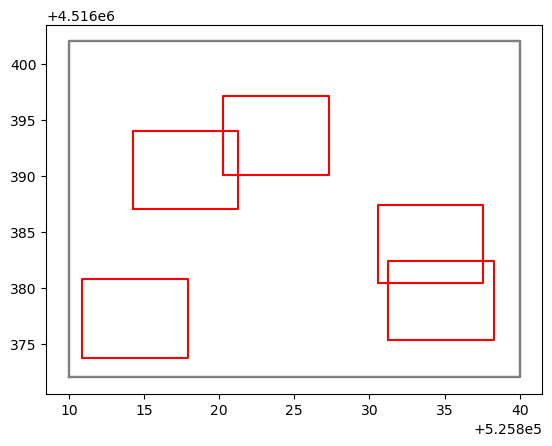

29-30_2


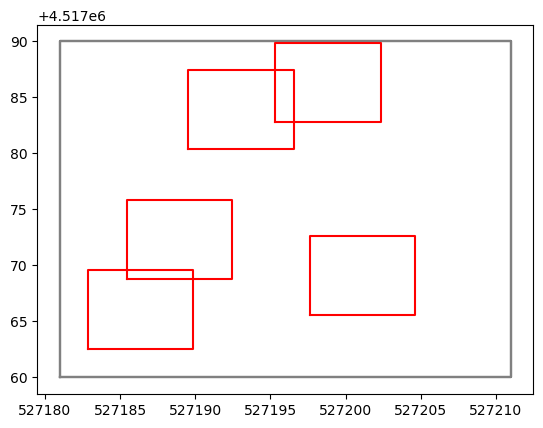

CN_58


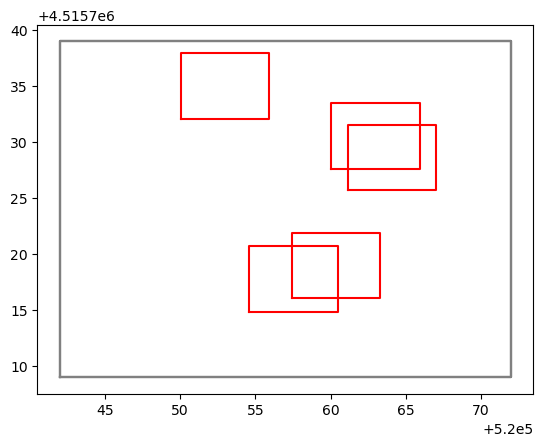

5W_6


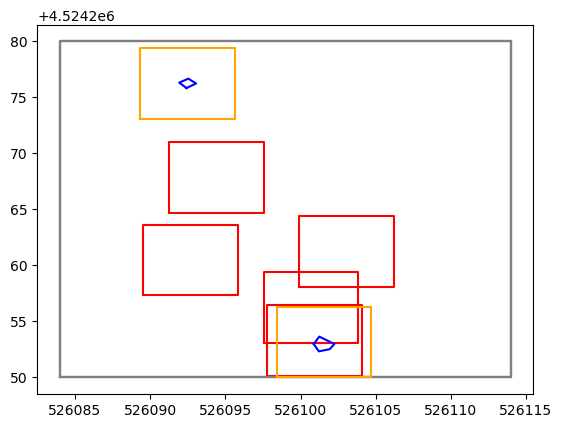

29-30_42


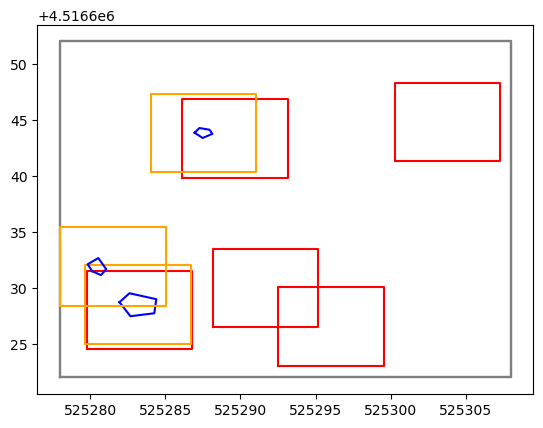

CN_57


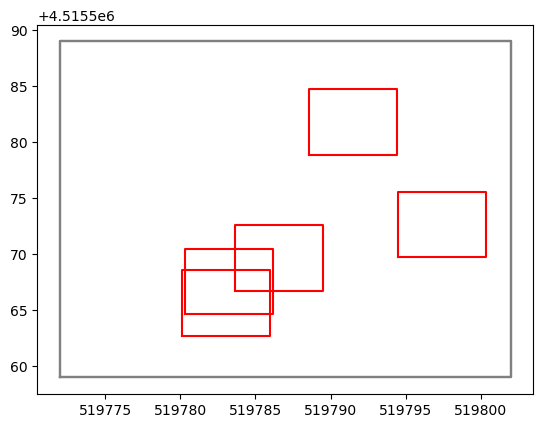

22E_3


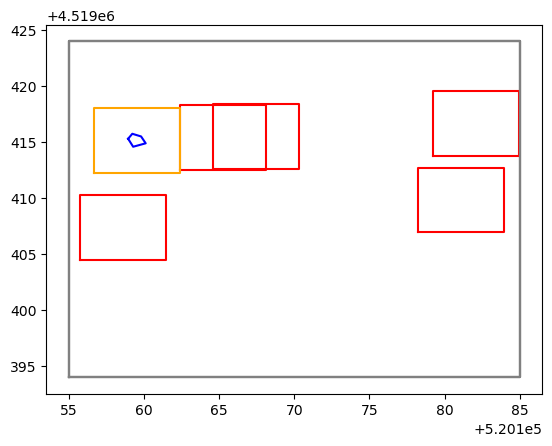

CN_29


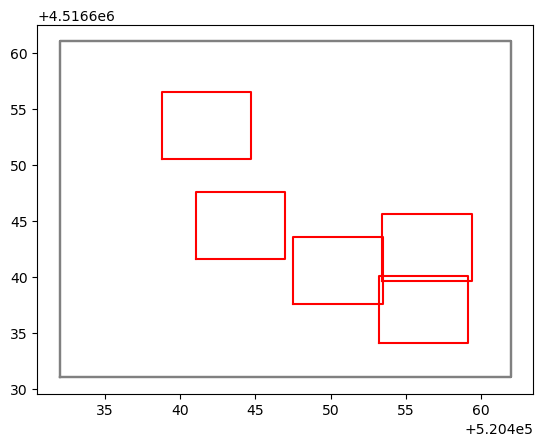

5W_2


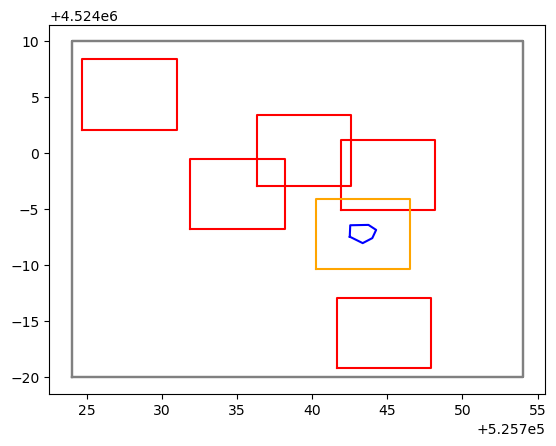

22E_6


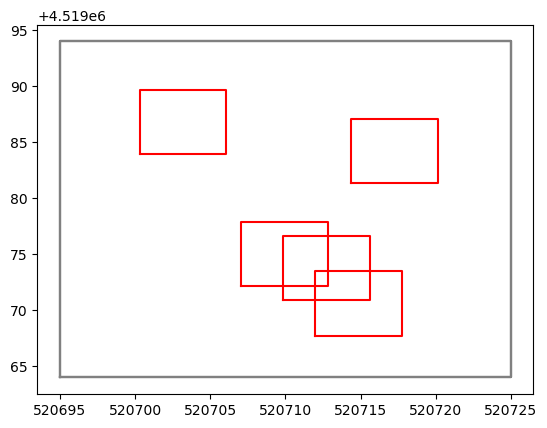

CN_33


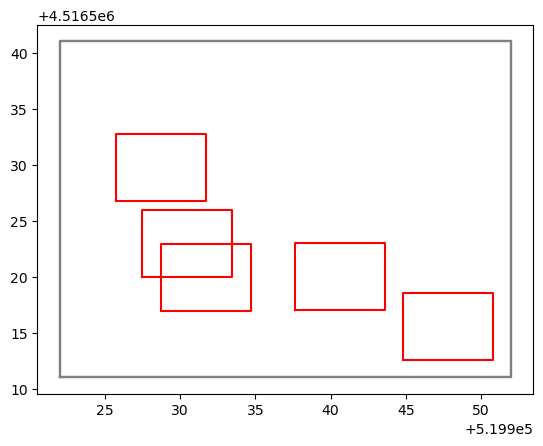

CN_19


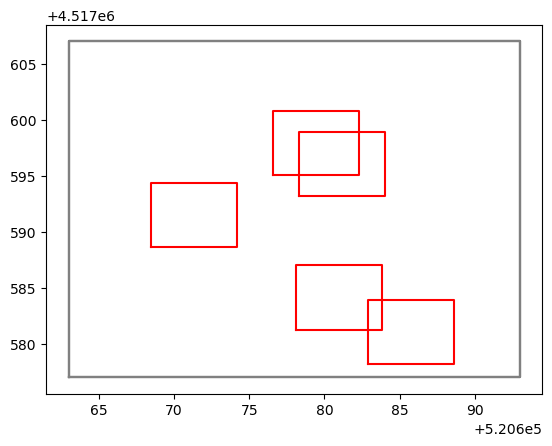

29-30_30


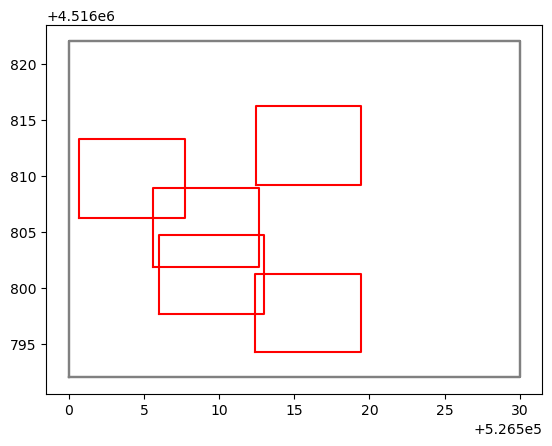

29-30_4


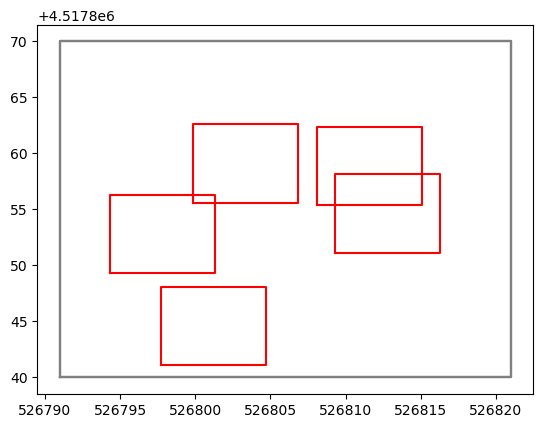

CN_25


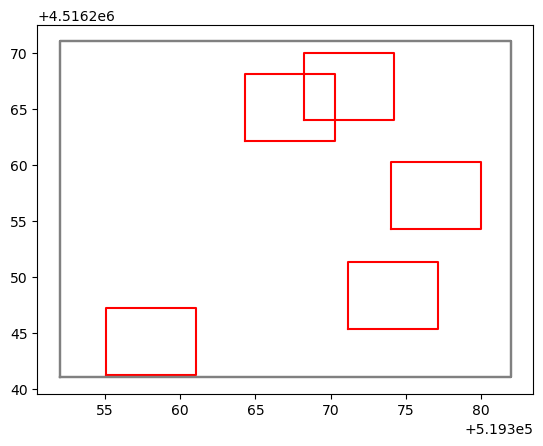

CN_24


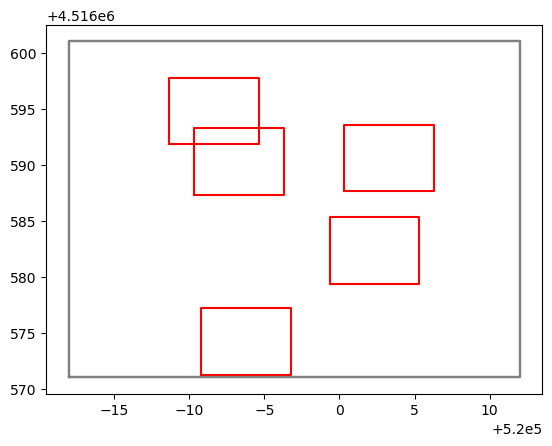

22W_15


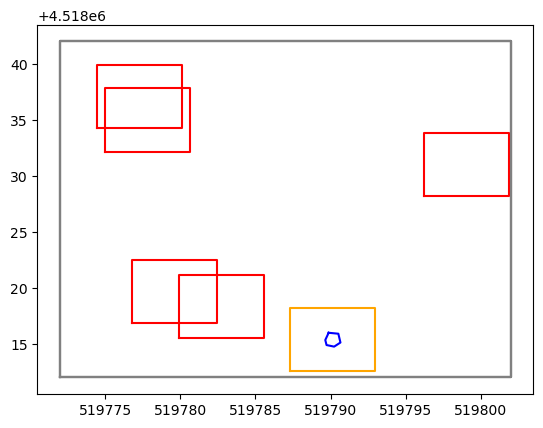

29-30_26


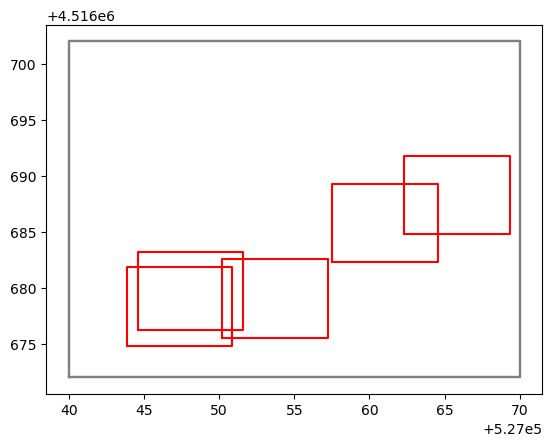

29-30_3


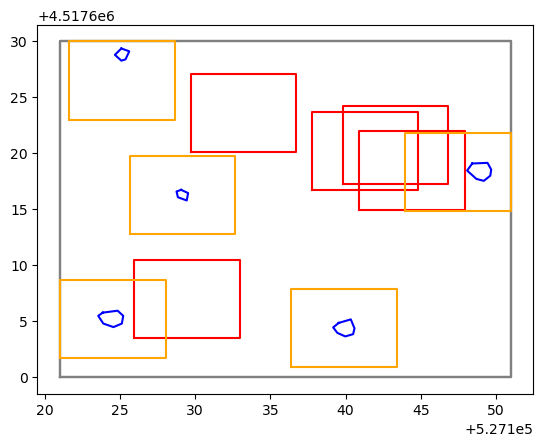

CN_21


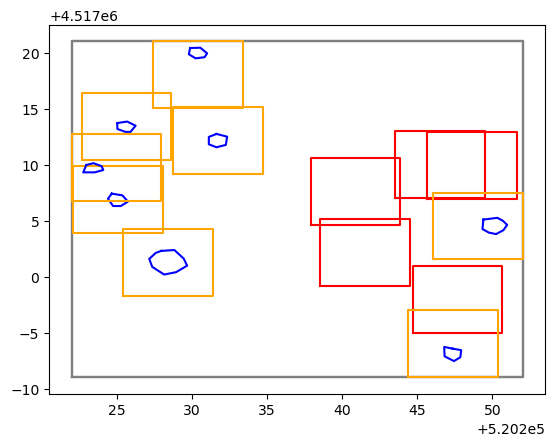

22E_1


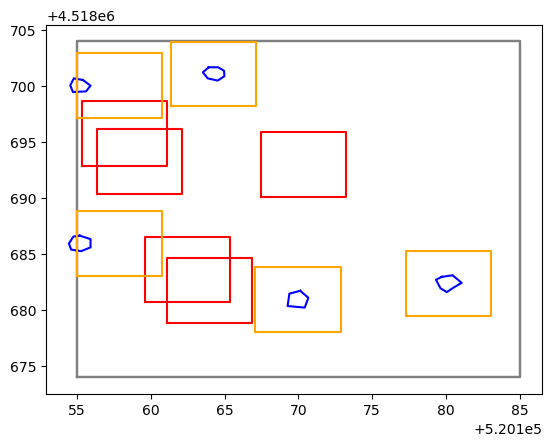

5W_1


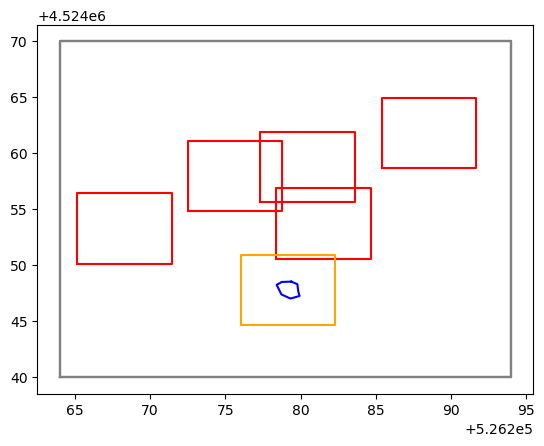

29-30_6


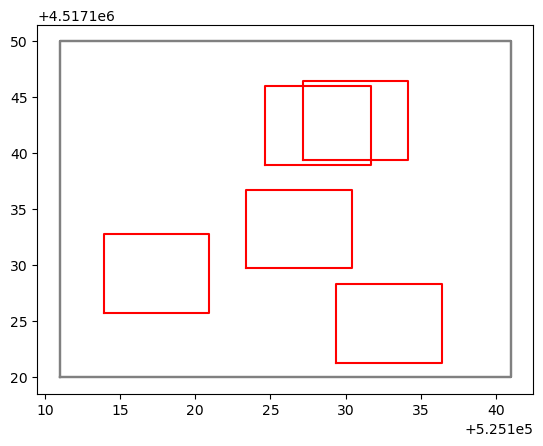

22E_10


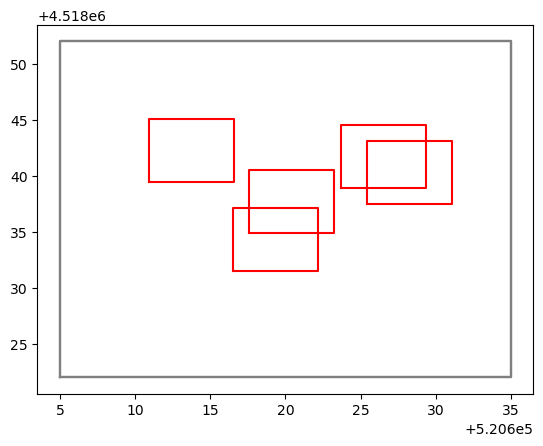

29-30_9


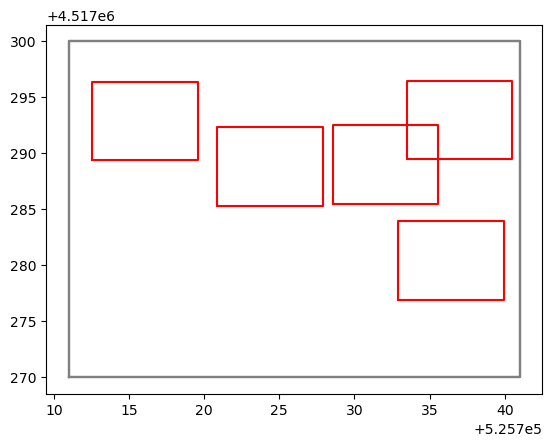

22W_4


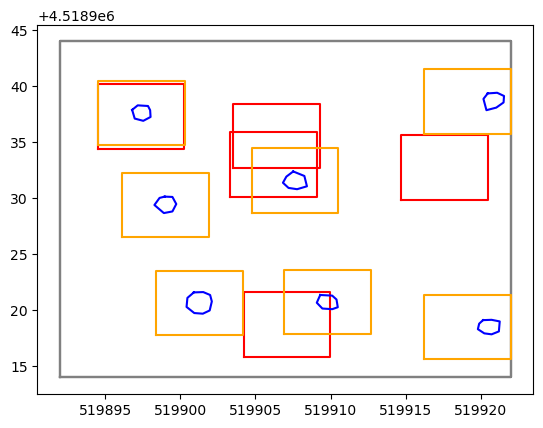

22W_3


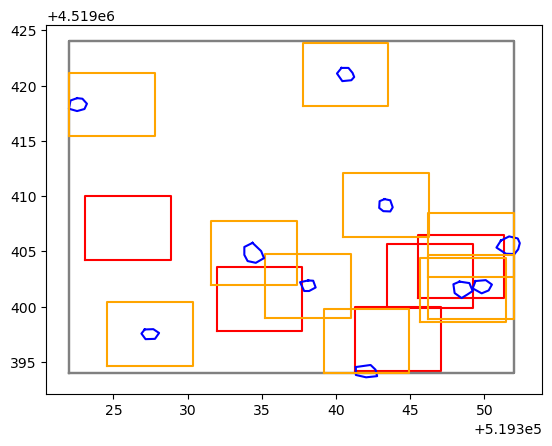

CN_12


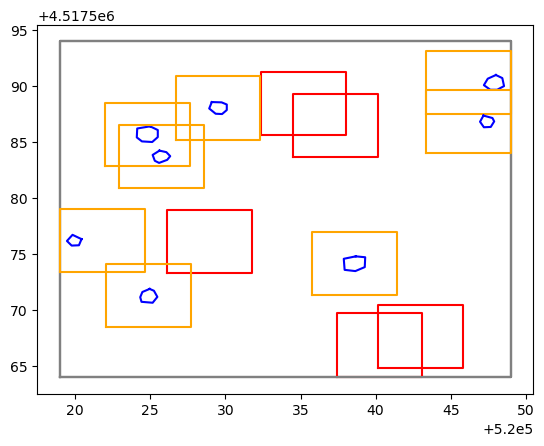

CN_0


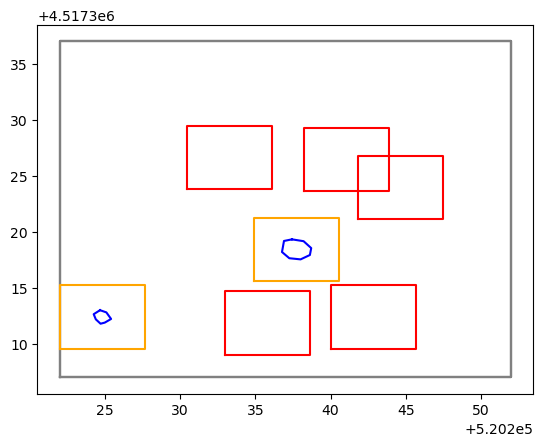

29-30_44


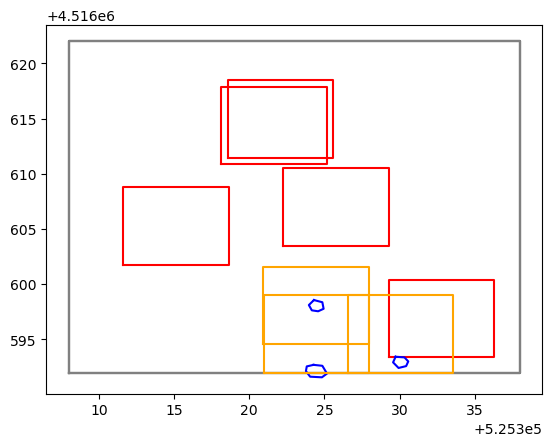

CN_31


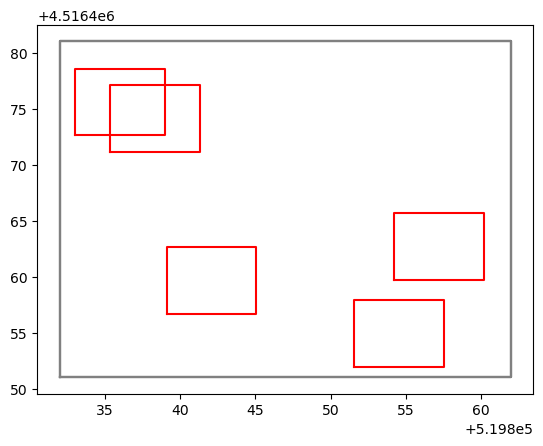

29-30_14


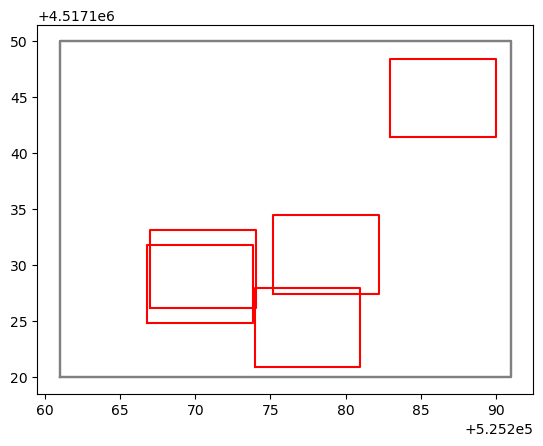

CN_59


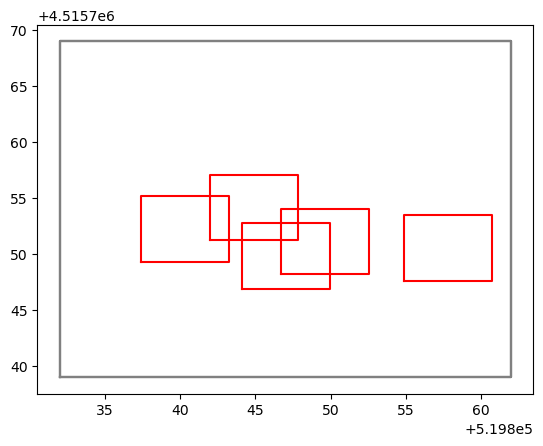

5W_3


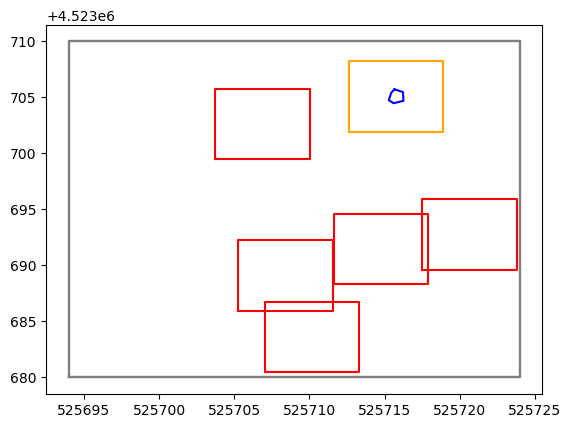

CN_50


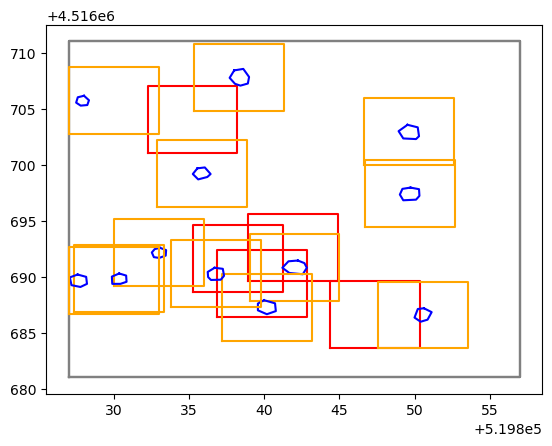

CN_44


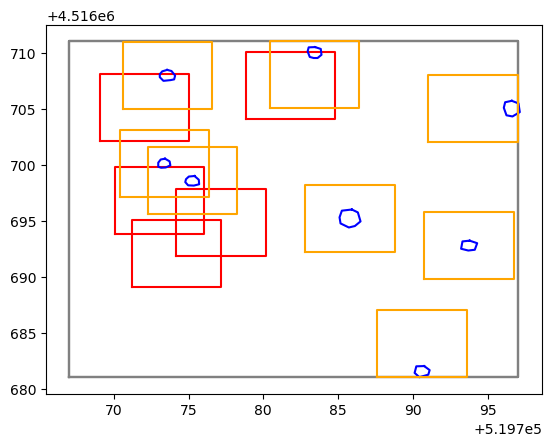

29-30_31


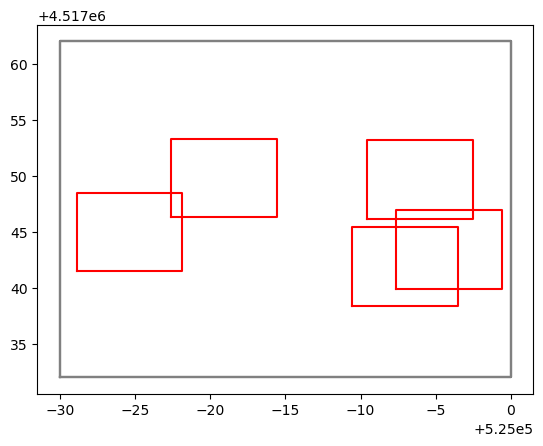

29-30_17


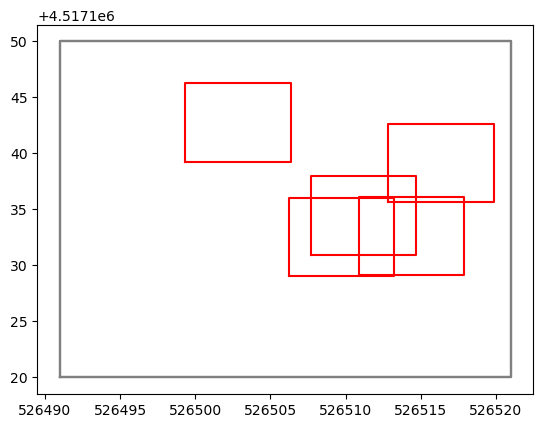

CN_56


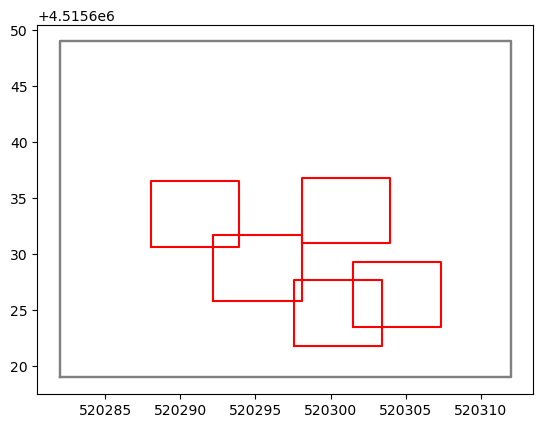

22W_1


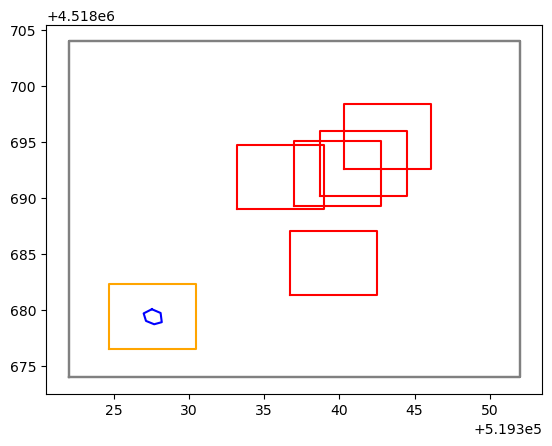

22E_2


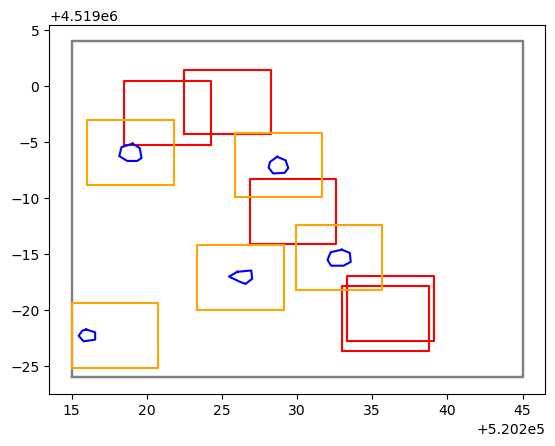

22E_4


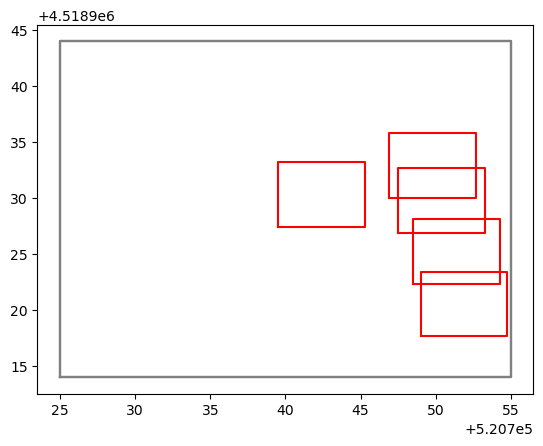

CN_30


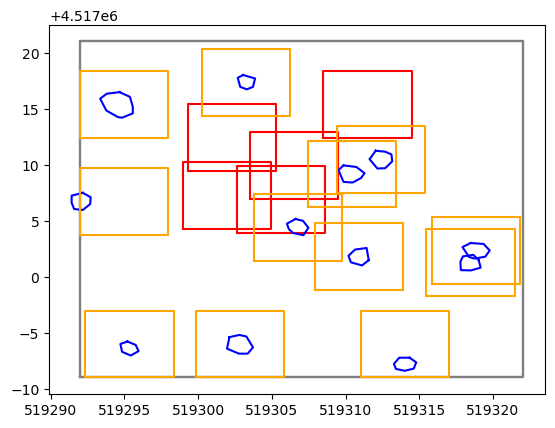

29-30_28


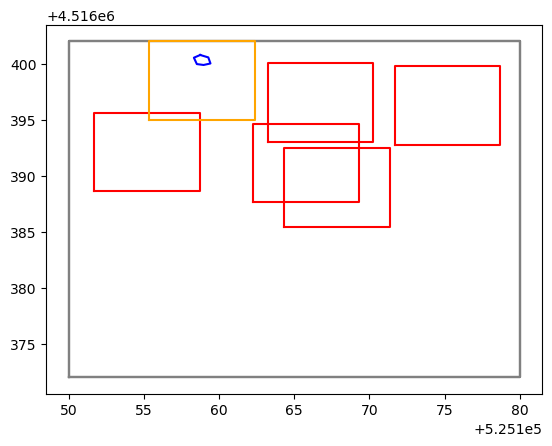

CN_16


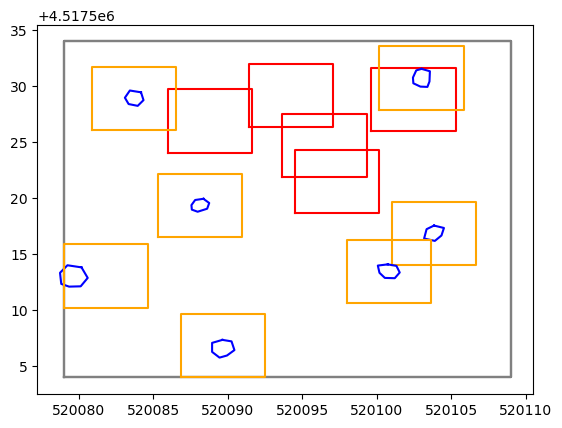

29-30_20


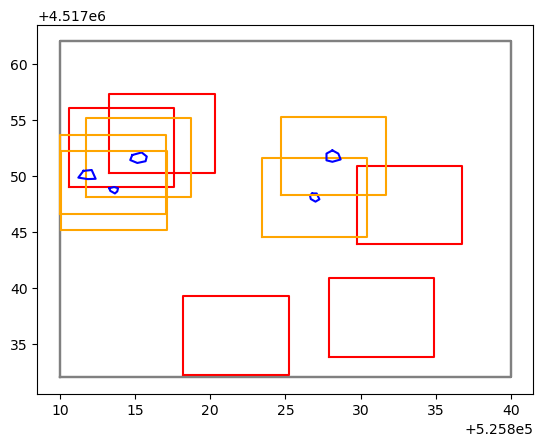

In [14]:
# loop through all tiles, select 5 random windows and select 5 windows from 
for ID in df_tiles['ID'][(df_tiles['trainer'] != 'Nick') &
                         (df_tiles['Digitize'] == 1)] :
    print(ID)
    # get unique ID of training tile from training dataset
    #ID = train_polys.Tile.unique()[0]
    # subset only the training polygons associated with the tile ID
    #train_polys_sub = train_polys[train_polys['Tile'] == ID]

    # get the path base to the imagery associated with the training tile
    if external_path is None:
        tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
    else:
        tilePATH = os.path.join(external_path,
                                df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0])
        
    # get the x/y coordinates of the bounding box for the training polygon within the tile
    box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
    box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
    # get the box coordinate pairs
    ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
    # create a polygon from the coordinate pairs
    tile_geom = Polygon([ll, ul, ur, lr])
    # create the full path to the RGB image of the training tile
    tile_f = os.path.join(os.path.dirname(train_tiles_DIR), tilePATH + 'rgb.tif')

    with rio.open(tile_f) as src_rgb_samp:   
        res_samp = src_rgb_samp.transform[0]

    # set window size
    win_pix = 32 * 12
    win_size = win_pix * res_samp
    
    fig, ax = plt.subplots()
    
    # get the subset of training polygons from the tile
    train_polys_sub = train_polys[train_polys['Tile'] == ID]
    
    # remove any burrow polygons whose centroid is outside the training polygon
    train_polys_sub = train_polys_sub[~train_polys_sub.apply(lambda x: any([x.geometry.centroid.coords[0][0] < ll[0],
                                                                            x.geometry.centroid.coords[0][0] > ur[0],
                                                                            x.geometry.centroid.coords[0][1] < ll[1],
                                                                            x.geometry.centroid.coords[0][1] > ur[1]]),
                                                             axis=1)]
    for i in range(5):
        ll_rand = (random.uniform(ll[0], lr[0] - win_size), random.uniform(ll[1], ul[1] - win_size))
        rand_geom = Polygon([ll_rand, (ll_rand[0], ll_rand[1] + win_size),
                             tuple(map(lambda x: x+win_size, ll_rand)), (ll_rand[0] + win_size, ll_rand[1])])
        crop_and_save(tile_f, train_polys_sub, rand_geom.buffer(0.02), 'rand_' + str(i), win_pix)

        ax.plot(*tile_geom.exterior.xy, c='grey')
        ax.plot(*rand_geom.exterior.xy, c='red')
    for poly_id, poly in train_polys_sub.iterrows():
        poly_coords_x = np.array(poly.geometry.bounds)[[0, 2]]
        poly_coords_y = np.array(poly.geometry.bounds)[[1, 3]]
        poly_coords_x[0] = (poly_coords_x[0] + poly_coords_x[1])/2 - win_size/2.0
        poly_coords_y[0] = (poly_coords_y[0] + poly_coords_y[1])/2 - win_size/2.0
        if poly_coords_x[0] < ll[0]:
            poly_coords_x[0] = ll[0]
        if( poly_coords_x[0] + win_size) > lr[0]:
            poly_coords_x[0] = lr[0] - win_size
        if poly_coords_y[0] < ll[1]:
            poly_coords_y[0] = ll[1]
        if (poly_coords_y[0] + win_size) > ur[1]:
            poly_coords_y[0] = ur[1] - win_size 
        poly_coords_x[1] = poly_coords_x[0] + win_size
        poly_coords_y[1] = poly_coords_y[0] + win_size
        # get the box coordinate pairs
        poly_ll, poly_ul, poly_lr, poly_ur = list(itertools.product(poly_coords_x, poly_coords_y))
        # create a polygon from the coordinate pairs
        poly_geom = Polygon([poly_ll, poly_ul, poly_ur, poly_lr])

        crop_and_save(tile_f, train_polys_sub, poly_geom.buffer(0.05), 'poly_' + str(poly_id), win_pix)

        ax.plot(*poly.geometry.exterior.xy, c='blue')
        ax.plot(*poly_geom.exterior.xy, c='orange')
    plt.show(block=False)
    time.sleep(3)
    plt.close(fig)

In [15]:
print("complete")

complete


## Other testing

In [ ]:
ID = '22E_1'
tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
tile_f = os.path.join(os.path.dirname(train_tiles_DIR), tilePATH + 'rgb.tif')
tile_basename_rgb = os.path.basename(tile_f)
prefix = 'poly_81_'

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
with rio.open(os.path.join(outDIR_imgs, prefix + tile_basename_rgb)) as src:
    show(src.read(), ax=ax)
    with rio.open(os.path.join(outDIR_labs, prefix + re.sub('_rgb', '_labels', tile_basename_rgb))) as src_lab:
        show(src_lab.read(), ax=ax, alpha=0.3)

In [ ]:
with rio.open(os.path.join(outDIR_imgs, prefix + re.sub('_rgb', '_ndvi', tile_basename_rgb))) as src:
    plt.figure(figsize=(4, 4))
    show(src.read())

In [ ]:
with rio.open(os.path.join(outDIR_imgs, prefix + re.sub('_rgb', '_dsm', tile_basename_rgb))) as src:
    plt.figure(figsize=(4, 4))
    show(src.read())

In [ ]:
with rio.open(os.path.join(outDIR_imgs, prefix + re.sub('_rgb', '_shade', tile_basename_rgb))) as src:
    plt.figure(figsize=(4, 4))
    show(src.read())

In [ ]:
with rio.open(os.path.join(outDIR_imgs, prefix + re.sub('_rgb', '_tpi', tile_basename_rgb))) as src:
    plt.figure(figsize=(4, 4))
    show(src.read())

In [ ]:
for ID, train_polys_sub in tqdm(train_polys.groupby('Tile')):
    print(ID)
    # get unique ID of training tile from training dataset
    #ID = train_polys.Tile.unique()[0]
    # subset only the training polygons associated with the tile ID
    #train_polys_sub = train_polys[train_polys['Tile'] == ID]

    # get the path base to the imagery associated with the training tile
    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
    # get the x/y coordinates of the bounding box for the training polygon within the tile
    box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
    box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
    # get the box coordinate pairs
    ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
    # create a polygon from the coordinate pairs
    tile_geom = Polygon([ll, ul, ur, lr])
    # create the full path to the RGB image of the training tile
    tile_f = os.path.join(os.path.dirname(train_tiles_DIR), tilePATH + 'rgb.tif')

    with rio.open(tile_f) as src_rgb:
        profile_rgb = src_rgb.meta
        rgb_out, transform_out = mask.mask(src_rgb,
                                           [tile_geom],
                                           crop=True)
        ll_i = src_rgb.index(*ll)
        ur_i = src_rgb.index(*ur)
        label = rasterize(train_polys_sub.geometry, out_shape=src_rgb.shape, transform=src_rgb.transform)
        label = label[ll_i[1]:ur_i[1], ur_i[0]:ll_i[0]]
        profile_rgb.update({'dtype': 'int16',
                            'width': label.shape[1],
                            'height': label.shape[0],
                            'transform': transform_out})
        profile_single = profile_rgb.copy()
        profile_single.update({'count': 1})
        profile_single_float = profile_single.copy()
        profile_single_float.update({'dtype': 'float64'})
        tile_basename_rgb = os.path.basename(tile_f)
        with rio.open(os.path.join(outDIR_imgs, 'cnn_' + tile_basename_rgb), 'w', **profile_rgb) as dst:
            dst.write(rgb_out)
        with rio.open(os.path.join(outDIR_labs, 'cnn_' + re.sub('_rgb', '_labels', tile_basename_rgb)), 'w', **profile_single) as dst:
            dst.write(label, 1)
        for suffix in ['ndvi', 'dsm', 'shade', 'tpi']:
            with rio.open(re.sub('rgb', suffix, tile_f)) as src_i:
                profile_i = src_i.profile
                i_out = src_i.read(out_shape=(
                    src_i.count,
                    src_rgb.meta['width'],
                    src_rgb.meta['height']),
                                   resampling=Resampling.bilinear)
                i_out = i_out[:, ll_i[1]:ur_i[1], ur_i[0]:ll_i[0]]
                profile_i.update({'width': i_out.shape[2],
                                  'height': i_out.shape[1],
                                  'transform': transform_out})
                with rio.open(os.path.join(outDIR_imgs, 'cnn_' + re.sub('rgb', suffix, tile_basename_rgb)), 'w', **profile_i) as dst:
                    dst.write(i_out)

In [ ]:
ID = 'CN_30'
tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
tile_f = os.path.join(os.path.dirname(train_tiles_DIR), tilePATH + 'rgb.tif')
tile_basename_rgb = os.path.basename(tile_f)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
with rio.open(os.path.join(outDIR_imgs, 'cnn_' + tile_basename_rgb)) as src:
    show(src.read(), ax=ax)
    with rio.open(os.path.join(outDIR_labs, 'cnn_' + re.sub('_rgb', '_labels', tile_basename_rgb))) as src_lab:
        show(src_lab.read(), ax=ax, alpha=0.2)

In [ ]:
with rio.open(os.path.join(outDIR_imgs, 'cnn_' + re.sub('_rgb', '_ndvi', tile_basename_rgb))) as src:
    plt.figure(figsize=(12, 12))
    show(src.read())

In [ ]:
with rio.open(os.path.join(outDIR_imgs, 'cnn_' + re.sub('_rgb', '_dsm', tile_basename_rgb))) as src:
    plt.figure(figsize=(12, 12))
    show(src.read())

In [ ]:
with rio.open(os.path.join(outDIR_imgs, 'cnn_' + re.sub('_rgb', '_shade', tile_basename_rgb))) as src:
    plt.figure(figsize=(12, 12))
    show(src.read())

In [ ]:
with rio.open(os.path.join(outDIR_imgs, 'cnn_' + re.sub('_rgb', '_tpi', tile_basename_rgb))) as src:
    plt.figure(figsize=(12, 12))
    show(src.read())